<h1>6. Machine Learning Models </h1>

In [16]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
import math
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, accuracy_score, log_loss
import xgboost as xgb

## 6.2 Load data

In [2]:
import pandas as pd
data = pd.read_csv("all_features.csv", nrows = 10000)

In [3]:
data.shape

(10000, 628)

In [4]:
data.head()

,id,is_duplicate,q1len,q2len,q1+q2_len,q1-q2_len,q1_words,q2_words,total_words,words_difference,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,66,57,123,9,14,12,26,2,...,89.509871,-110.533625,-100.479424,90.664803,19.507948,-15.140525,-19.345136,-129.408695,-118.284831,89.844395
1,1,0,51,88,139,37,8,13,21,5,...,81.915579,52.010940,91.056819,-0.052428,-165.972075,103.077540,-83.073252,-68.480301,-117.666431,173.873648
2,2,0,73,59,132,14,14,10,24,4,...,88.559925,19.308219,128.521377,126.306732,-44.066754,148.308988,152.486339,-244.803431,2.997449,250.107358
3,3,0,50,65,115,15,11,9,20,2,...,46.109540,-82.958610,25.998560,32.833132,-39.527964,20.387944,-82.090781,-163.982581,34.050951,9.135598
4,4,0,76,39,115,37,13,7,20,6,...,113.437943,-65.196309,123.960645,-68.888675,-154.013207,-66.353766,8.589358,-33.926499,-25.562273,3.669500


In [5]:
y_true = data['is_duplicate']
data.drop([ 'id','is_duplicate'], axis=1, inplace=True)

<h2> 6.3 Converting strings to numerics </h2>

In [6]:
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    

In [7]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 6.4 Random train test split( 70:30) </h2>

In [8]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [9]:
X_test.head()

,q1len,q2len,q1+q2_len,q1-q2_len,q1_words,q2_words,total_words,words_difference,simillar_words_count,word_share,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
6170,65,45,110,20,12,9,21,3,8,0.380952,...,14.393129,-239.719940,-63.524810,59.881201,72.142992,5.754190,190.774236,-164.015844,-123.346762,48.104898
1315,57,63,120,6,11,12,23,1,9,0.391304,...,124.151477,-64.362867,-39.893544,24.476162,-138.759167,11.686112,10.615734,-81.583238,-164.554990,123.626516
3937,40,58,98,18,9,9,18,0,3,0.166667,...,40.455519,-57.670519,-43.233555,14.638245,-59.457570,-41.413203,-9.696043,-105.352894,-42.711663,33.374171
1927,26,32,58,6,5,6,11,1,0,0.000000,...,83.363547,-60.630362,103.437835,-44.875103,-44.730358,5.790354,-1.964831,-60.965828,-67.735530,19.255421
4543,38,49,87,11,5,9,14,4,2,0.142857,...,49.833147,-56.589051,16.491375,-3.369594,-60.000676,-53.776843,1.093084,-20.636595,-73.359813,8.243026


In [10]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 626)
Number of data points in test data : (3000, 626)


In [11]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6288571428571429 Class 1:  0.37114285714285716
---------- Distribution of output variable in test data ----------
Class 0:  0.629 Class 1:  0.371


### Confusion matrix

In [12]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
   
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [13]:
labels = np.array([0,1])

<h2> 6.5 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8604848735479542


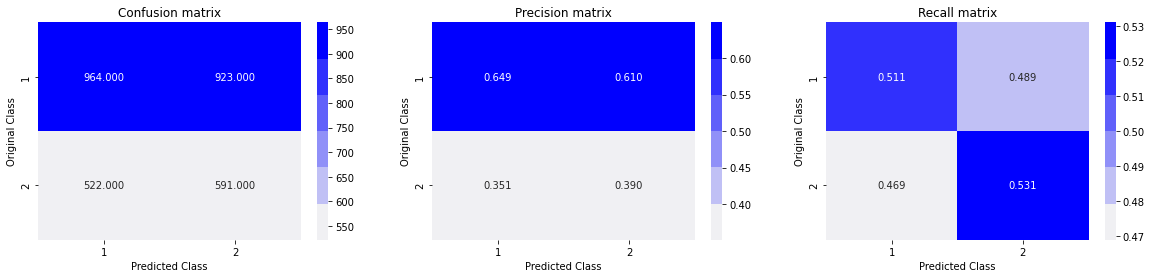

In [14]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 6.6 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6594859818900423
For values of alpha =  0.0001 The log loss is: 0.6594859818900423
For values of alpha =  0.001 The log loss is: 0.6206127714643227
For values of alpha =  0.01 The log loss is: 0.587009101669169
For values of alpha =  0.1 The log loss is: 0.5835178680554756
For values of alpha =  1 The log loss is: 0.592601467350604
For values of alpha =  10 The log loss is: 0.5786385412166767


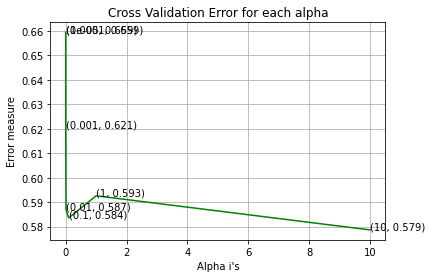

For values of best alpha =  10 The train log loss is: 0.5236009315943219
For values of best alpha =  10 The test log loss is: 0.5786385412166767
Total number of data points : 3000


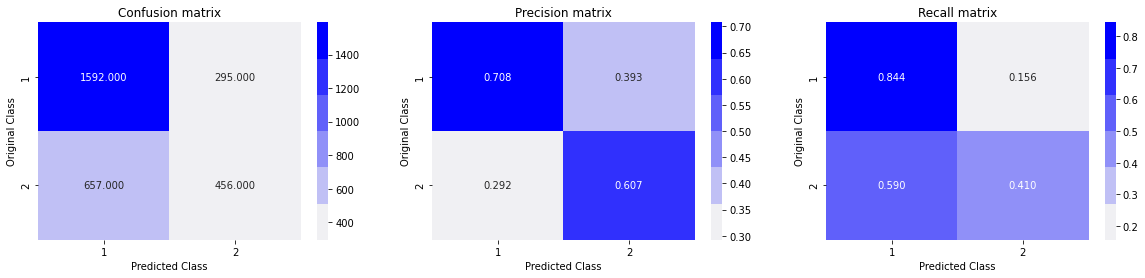

In [17]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 6.7 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6594859818900423
For values of alpha =  0.0001 The log loss is: 0.6594859818900423
For values of alpha =  0.001 The log loss is: 0.6594859818900423
For values of alpha =  0.01 The log loss is: 0.6594859818900423
For values of alpha =  0.1 The log loss is: 0.6594859818900423
For values of alpha =  1 The log loss is: 0.6594859818900423
For values of alpha =  10 The log loss is: 0.6594859818900423


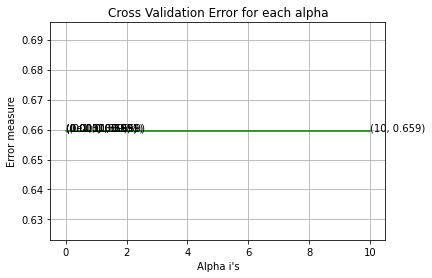

For values of best alpha =  1e-05 The train log loss is: 0.6595612003985919
For values of best alpha =  1e-05 The test log loss is: 0.6594859818900423
Total number of data points : 3000


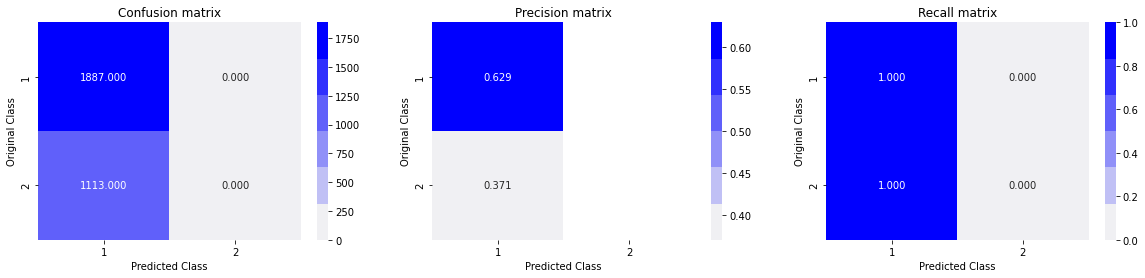

In [18]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 6.8 XG Boost with hyperparameter tuning </h2>

In [19]:
# DMatrix objects are created for training and testing data respectively.
# The DMatrix object is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.
dm_train = xgb.DMatrix(X_train, label=y_train)
dm_test = xgb.DMatrix(X_test, label=y_test)

In [20]:
# range of parameters for gridsearch cv
gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(4,8)
                    for min_child_weight in range(10,15)]

In [21]:
# parameters
params = {}
params['objective'] = 'binary:logistic' # The objective is set to 'binary:logistic' which means that the model will be used 
                                        #for binary classification with a logistic loss function
params['eval_metric'] = 'logloss' # The eval_metric is set to 'logloss' which means that the model's performance will 
                                  # be evaluated using the logarithmic loss metric.
params['eta'] = 0.02 # learning rate

In [22]:
logloss_min = float("Inf") # set logloss to infinity
best_params = None

# start gridsearchcv on max depth and min child weight
for max_depth, min_child_weight in gridsearch_params:
    
    params['max_depth'] = max_depth # maximum depth of the  decision tree.
    params['min_child_weight'] = min_child_weight # Minimum sum of instance weight needed in a child
    
    
    # perform cross-validation on the XGBoost model 
    xg_cvresults = xgb.cv(params, dtrain = dm_train, num_boost_round = 400,
                      seed = 0, nfold=5, metrics = {'logloss'}, early_stopping_rounds = 20,)
    
    # store the minimum mean logloss value obtained from the cross-validation for the current 
    # combination of max_depth and min_child_weight hyperparameters.
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    
    print("max_depth: {} | min_child_weight: {} with Logloss: {:.3}\n".format(max_depth,min_child_weight,logloss_mean))
    
    # If the current logloss value is less than the previously recorded minimum value, the current values of max_depth 
    # and min_child_weight are considered as the new best hyperparameters, and their logloss value is set as the new minimum.
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = (max_depth, min_child_weight)

        
print("Best Parameters: max_depth: {} | min_child_weight: {} with Logloss: {:.3f}". format(best_params[0], 
                                                                                  best_params[1], logloss_min))

max_depth: 4 | min_child_weight: 10 with Logloss: 0.457

max_depth: 4 | min_child_weight: 11 with Logloss: 0.457

max_depth: 4 | min_child_weight: 12 with Logloss: 0.457

max_depth: 4 | min_child_weight: 13 with Logloss: 0.458

max_depth: 4 | min_child_weight: 14 with Logloss: 0.458

max_depth: 5 | min_child_weight: 10 with Logloss: 0.451

max_depth: 5 | min_child_weight: 11 with Logloss: 0.452

max_depth: 5 | min_child_weight: 12 with Logloss: 0.452

max_depth: 5 | min_child_weight: 13 with Logloss: 0.453

max_depth: 5 | min_child_weight: 14 with Logloss: 0.452

max_depth: 6 | min_child_weight: 10 with Logloss: 0.448

max_depth: 6 | min_child_weight: 11 with Logloss: 0.449

max_depth: 6 | min_child_weight: 12 with Logloss: 0.449

max_depth: 6 | min_child_weight: 13 with Logloss: 0.448

max_depth: 6 | min_child_weight: 14 with Logloss: 0.449

max_depth: 7 | min_child_weight: 10 with Logloss: 0.446

max_depth: 7 | min_child_weight: 11 with Logloss: 0.447

max_depth: 7 | min_child_weight

In [24]:
import time
start_time = time.time()
params = {}
# The objective is set to 'binary:logistic' which means that the model will be used for binary classification with a logistic loss function
params['objective'] = 'binary:logistic' 
# The eval_metric is set to 'logloss' which means that the model's performance will be evaluated using the logarithmic loss metric.
params['eval_metric'] = 'logloss'
params['eta'] = 0.02 # learning rate
params['max_depth'] = 7 # maximum depth of the  decision tree.
params['min_child_weight'] = 12 # Minimum sum of instance weight needed in a child

# DMatrix objects are created for training and testing data respectively.
# The DMatrix object is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.
d_train = xgb.DMatrix(X_train, label = y_train)
d_test = xgb.DMatrix(X_test, label = y_test)

#watchlist is created which contains the training and validation data. 
# This will allow XGBoost to perform early stopping if the performance on the validation set does not improve after a certain number of rounds.
watchlist = [(d_train, 'train'), (d_test, 'valid')]

# tarin model
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
# prediction on test data.
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=labels, eps=1e-15))
print("--- %s seconds ---" % (time.time() - start_time))

[0]	train-logloss:0.68568	valid-logloss:0.68664
[10]	train-logloss:0.62339	valid-logloss:0.63336
[20]	train-logloss:0.57574	valid-logloss:0.59445
[30]	train-logloss:0.53766	valid-logloss:0.56545
[40]	train-logloss:0.50617	valid-logloss:0.54341
[50]	train-logloss:0.48110	valid-logloss:0.52657
[60]	train-logloss:0.45889	valid-logloss:0.51263
[70]	train-logloss:0.44105	valid-logloss:0.50238
[80]	train-logloss:0.42349	valid-logloss:0.49307
[90]	train-logloss:0.40787	valid-logloss:0.48513
[100]	train-logloss:0.39525	valid-logloss:0.47912
[110]	train-logloss:0.38394	valid-logloss:0.47452
[120]	train-logloss:0.37364	valid-logloss:0.47107
[130]	train-logloss:0.36497	valid-logloss:0.46810
[140]	train-logloss:0.35678	valid-logloss:0.46476
[150]	train-logloss:0.34998	valid-logloss:0.46249
[160]	train-logloss:0.34282	valid-logloss:0.46018
[170]	train-logloss:0.33550	valid-logloss:0.45848
[180]	train-logloss:0.32865	valid-logloss:0.45678
[190]	train-logloss:0.32146	valid-logloss:0.45527
[200]	train

Total number of data points : 3000


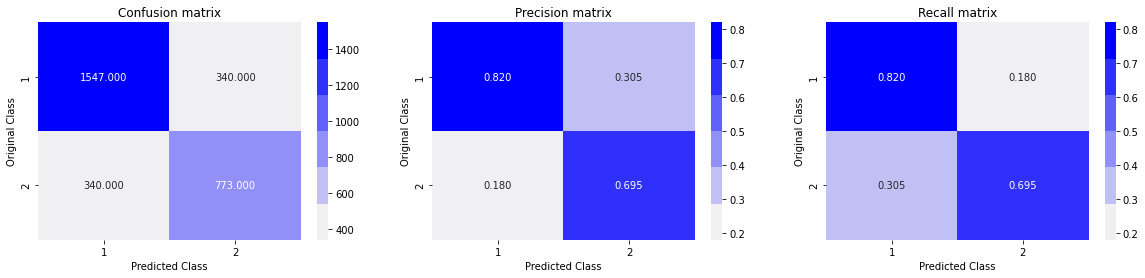

In [25]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>save best model</h2>

In [26]:
import pickle
filename = 'model.sav'
pickle.dump(bst, open(filename, 'wb'))